In [20]:
# Import built-in libraries
import os
from os.path import abspath

# Import external libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

# Import internal libraries
from src.plot_confusion_matrix import plot_confusion_matrix

In [2]:
# Load all data
demo = pd.read_csv(abspath("../data/T_demo.csv"))
stage = pd.read_csv(abspath("../data/T_stage.csv"))

# Biomarkers
cre = pd.read_csv(abspath("../data/T_creatinine.csv"))
dbp = pd.read_csv(abspath("../data/T_DBP.csv"))
sbp = pd.read_csv(abspath("../data/T_SBP.csv"))
hgb = pd.read_csv(abspath("../data/T_HGB.csv"))
glu = pd.read_csv(abspath("../data/T_glucose.csv"))
ldl = pd.read_csv(abspath("../data/T_ldl.csv"))

# Medication
meds = pd.read_csv(abspath("../data/T_meds.csv"))

- Ok, so we have time series data now what?
- First thing is to identify tendencies on the data.
- My first try would be taking into account only the difference between the last and first point.

In [3]:
# Group values by patient id
# Calculate the difference between the latest and first measurement for all biomarkers
cre_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in cre.groupby("id")}, name="cre")
dbp_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in dbp.groupby("id")}, name="dbp")
sbp_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in sbp.groupby("id")}, name="sbp")
hgb_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in hgb.groupby("id")}, name="hgb")
glu_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in glu.groupby("id")}, name="glu")
ldl_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in ldl.groupby("id")}, name="ldl")


# Create a new data frame with the differences
biomarkers_diff = pd.concat([cre_s, dbp_s, sbp_s, hgb_s, glu_s, ldl_s], axis=1)
biomarkers_diff

,cre,dbp,sbp,hgb,glu,ldl
0,-0.06,-11.03,13.39,-0.38,-0.46,-3.59
1,0.46,18.50,-7.80,-1.04,-0.18,-16.33
2,-0.31,10.39,3.57,-0.15,-0.20,25.52
3,0.16,-12.64,-4.58,-1.08,-0.66,1.71
4,-0.41,22.34,37.67,-1.58,2.24,6.30
...,...,...,...,...,...,...
295,-0.31,-0.30,-16.35,0.61,-0.64,12.02
296,-0.47,5.84,3.50,0.19,0.69,-8.61
297,0.06,13.68,-8.77,0.43,1.28,17.05
298,-0.06,-16.14,-6.19,1.96,-0.44,-16.98


In [4]:
# Binarize medication labels
# First let's create a dataframe with drugs as columns
meds_bin = pd.DataFrame()

# Iterate over the medications table grouping it by drug
for i,data in meds.groupby("drug"):
    
    # Create an empty array
    drug = np.zeros(demo.id.shape, dtype=bool)
    
    # For each drug, get the patients that are taking it
    # Change the value of the array to true only for the patients taking the drug
    drug[data.id.unique()]=True
    
    # Add a column for the specific drug to the binarized meds dataframe
    meds_bin[i]=drug

meds_bin

,atenolol,atorvastatin,bisoprolol,canagliflozin,carvedilol,dapagliflozin,irbesartan,labetalol,losartan,lovastatin,...,metoprolol,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan
0,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
296,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,True
298,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
# Binarize sex
sex = pd.get_dummies(demo.gender)["Male"].rename({"Male":"sex"})

# Binarize race remove unknown
race = pd.get_dummies(demo.race).drop("Unknown", axis=1)


In [6]:
# Let's first split the data into a training and a test set
# To do so we split the stage progression and take 15 ids each
# This way we have a 90:10 train-test split with a balanced test set

# Merging all data together
all_data = pd.concat([demo.age, sex, race, biomarkers_diff, meds_bin, stage.drop("id", axis=1)], axis=1)

# Separating progression trues and falses
true = all_data[all_data.Stage_Progress]
false = all_data[~all_data.Stage_Progress]

# Specify the test size
true_train, true_test = train_test_split(true, test_size=15, random_state=42)
false_train, false_test = train_test_split(false, test_size=15, random_state=42)

# Concatenate together true and false so we have only train, test
train = pd.concat([true_train, false_train])#.sort_values(by="id")
test = pd.concat([true_test, false_test])#.sort_values(by="id")

print(train.shape)
print(test.shape)

# # Make a single df with training/testing info
# train["is_train"] = True
# test["is_train"] = False
#
# # Merge
# split = pd.merge(train, test, how="outer").sort_values(by="id")
# split = split.reset_index(drop=True)


(270, 34)
(30, 34)


In [7]:
# all_ = pd.concat([demo.drop(["id", "race", "gender"], axis=1), biomarkers_diff, meds_bin], axis=1)
# all_train = all_[(split["is_train"]==True).values]
# all_test  = all_[(split["is_train"]==False).values]

print(f"Data points in train test {train.shape[0]}")
print(f"Data points in train test {test.shape[0]}")


Data points in train test 270
Data points in train test 30


In [8]:
%%time
# Train a random forest 
model = RandomForestClassifier(bootstrap=True, n_estimators=100000, oob_score=True, class_weight="balanced")
model.fit(train.drop("Stage_Progress", axis=1), train["Stage_Progress"].values.ravel())

C:\Users\darkg\anaconda3\envs\stable\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


Wall time: 3min 27s


RandomForestClassifier(class_weight='balanced', n_estimators=100000,
                       oob_score=True)

In [9]:
model.oob_score_

0.7925925925925926

In [10]:
model.score(test.drop("Stage_Progress", axis=1), test["Stage_Progress"].values.ravel())

0.7666666666666667

In [11]:
predicted = model.predict(test.drop("Stage_Progress", axis=1))

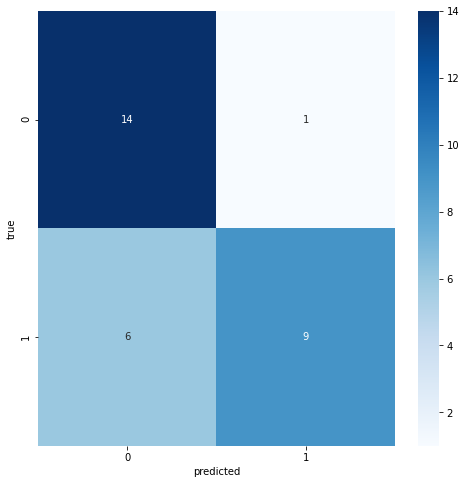

In [12]:
cm = confusion_matrix(test["Stage_Progress"], predicted)
plot_confusion_matrix(cm)
plt.show()

In [13]:
accuracy_score(test["Stage_Progress"], predicted)


0.7666666666666667

In [14]:
# Get feature importance
fi = pd.Series(model.feature_importances_, index=train.drop("Stage_Progress", axis=1).columns)

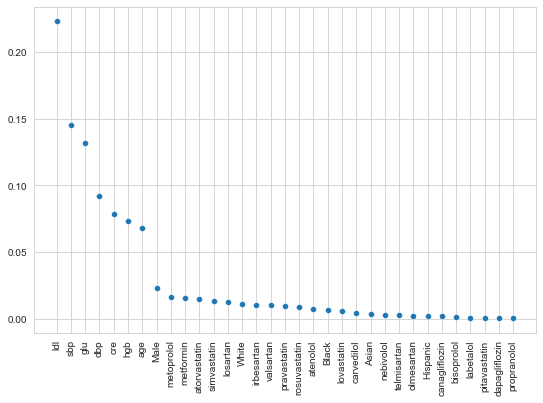

In [23]:
# Visualize feature importances
fi = fi.sort_values(ascending=False)
sns.set_style("whitegrid")
fig,ax = plt.subplots(1,1,figsize=(9,6))
sns.scatterplot(data=fi, ax=ax)
plt.xticks(rotation=90)

plt.show()

In [16]:
model.feature_importances_.shape

(33,)

In [22]:
print(classification_report(test["Stage_Progress"], predicted))

              precision    recall  f1-score   support

       False       0.70      0.93      0.80        15
        True       0.90      0.60      0.72        15

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.76        30
weighted avg       0.80      0.77      0.76        30

